## Meeting Follow-up Assistant Workflow

This implementation builds a workflow that takes a meeting transcript, extracts participants and action items using LLM parsing, resolves participant contact information through a custom tool, generates personalized notifications for each action item, and persists meeting data and participant information for future reference.

This implementation explores how to use memory to track people and meeting history across sessions, integrate custom tools for contact resolution, chain multiple processing steps in a linear workflow, and demonstrate practical AI automation that solves real workplace inefficiencies with minimal code complexity.


### Import required libraries

In [1]:
import os
import json
from datetime import datetime
from dotenv import load_dotenv
from langchain_core.tools import tool
from IPython.display import Image, display
from langchain.prompts import PromptTemplate
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import List, Dict, TypedDict, Literal, Annotated
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.store.memory import InMemoryStore

### Setup environment & LLM

In [2]:
# Load environment variables
load_dotenv()

# Set Google API key
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

# Initialize LLM
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

### Define state and tools

In [3]:
# Setup LangGraph memory and store
memory = MemorySaver()
store = InMemoryStore()


# State definitions for meeting workflow
class MeetingState(TypedDict):
    """State schema for the meeting processing workflow"""
    messages: Annotated[list, add_messages]
    transcript: str
    participants: List[str]
    action_items: List[Dict[str, str]]
    summary: str
    meeting_id: str
    notifications: List[str]


class QueryState(TypedDict):
    """State schema for the query processing workflow"""
    messages: Annotated[list, add_messages]
    user_query: str
    query_type: Literal["due_tasks", "meeting_summary", "action_items", "general"]
    user_name: str
    response: str
    meeting_participant: str


# Default contacts mapping
CONTACTS = {
    "john": "john@company.com",
    "jane": "jane@company.com",
    "bob": "bob@company.com",
    "anon": "anon@company.com",
    "sarah": "sarah@company.com",
}


# Tools for data management using LangGraph store
@tool
def save_meeting_data(meeting_id: str, meeting_data: Dict) -> str:
    """Save meeting data to LangGraph store"""
    store.put(("meetings", "data"), meeting_id, meeting_data)
    return f"Meeting {meeting_id} saved successfully"


@tool
def save_action_item(person: str, action_item: Dict) -> str:
    """Save action item to LangGraph store"""
    item_id = f"{action_item['meeting_id']}_{hash(action_item['task'])}"
    store.put(("action_items", person.lower()), item_id, action_item)
    return f"Action item saved for {person}"


@tool
def get_action_items_for_person(person: str) -> List[Dict]:
    """Get all action items for a person from LangGraph store"""
    try:
        items = store.search(("action_items", person.lower()))
        return [item.value for item in items]
    except:
        return []


@tool
def get_recent_meetings(limit: int = 5) -> List[Dict]:
    """Get recent meetings from LangGraph store"""
    try:
        meetings = store.search(("meetings", "data"))
        meeting_list = [meeting.value for meeting in meetings]
        return sorted(
            meeting_list, key=lambda x: x.get("meeting_id", ""), reverse=True
        )[:limit]
    except:
        return []


@tool
def get_contact_email(person: str) -> str:
    """Get email address for a person"""
    return CONTACTS.get(person.lower(), f"{person.lower()}@company.com")

### Define nodes

In [4]:
# Meeting Processing Nodes
def extract_meeting_data_node(state: MeetingState) -> Dict:
    """Extract participants, action items, and summary from transcript"""
    prompt = PromptTemplate(
        template="""Extract from this meeting transcript:
1. Participants (names only, first names)
2. Action items (who needs to do what with deadlines)
3. Meeting summary

Transcript: {transcript}

Return ONLY valid JSON:
{{
  "participants": ["name1", "name2"],
  "action_items": [{{"person": "name", "task": "description", "deadline": "date or N/A"}}],
  "summary": "brief summary"
}}""",
        input_variables=["transcript"],
    )
    
    response = llm.invoke(prompt.format(transcript=state["transcript"]))
    response_text = response.content.strip()
    
    try:
        if response_text.startswith('```'):
            import re
            json_match = re.search(r'```(?:json)?\s*(\{.*?\})\s*```', response_text, re.DOTALL)
            data = json.loads(json_match.group(1)) if json_match else {}
        else:
            data = json.loads(response_text)
    except (json.JSONDecodeError, ValueError):
        data = {
            "participants": [],
            "action_items": [],
            "summary": ""
        }
    
    return {
        "participants": data.get("participants", []),
        "action_items": data.get("action_items", []),
        "summary": data.get("summary", ""),
        "messages": [{"role": "assistant", "content": f"Extracted data from meeting transcript with {len(data.get('participants', []))} participants and {len(data.get('action_items', []))} action items"}]
    }

def save_meeting_node(state: MeetingState) -> Dict:
    """Save meeting data using LangGraph tools"""
    meeting_id = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    meeting_data = {
        "meeting_id": meeting_id,
        "transcript": state["transcript"],
        "summary": state["summary"],
        "participants": state["participants"],
        "action_items": state["action_items"],
        "timestamp": datetime.now().isoformat()
    }
    
    # Use tool to save meeting data
    save_result = save_meeting_data.invoke({"meeting_id": meeting_id, "meeting_data": meeting_data})
    
    # Save individual action items using tools
    for item in state["action_items"]:
        action_item_data = {
            "meeting_id": meeting_id,
            "person": item["person"],
            "task": item["task"],
            "deadline": item["deadline"],
            "status": "pending",
            "timestamp": datetime.now().isoformat()
        }
        save_action_item.invoke({"person": item["person"], "action_item": action_item_data})
    
    return {
        "meeting_id": meeting_id,
        "messages": [{"role": "assistant", "content": save_result}]
    }

def route_notifications_node(state: MeetingState) -> Dict:
    """Route notifications based on action items using tools"""
    notifications = []
    assigned_people = {item['person'] for item in state["action_items"]}
    
    for person in state["participants"]:
        email = get_contact_email.invoke({"person": person})
        
        if person in assigned_people:
            person_tasks = [item for item in state["action_items"] if item['person'] == person]
            for task in person_tasks:
                notifications.append(
                    f"To: {email}\n"
                    f"Subject: Action Item - {task['task']}\n"
                    f"Hi {person}, you have been assigned: {task['task']} (Due: {task['deadline']})"
                )
        else:
            notifications.append(
                f"To: {email}\n"
                f"Subject: Meeting Summary\n" 
                f"Hi {person}, meeting summary: {state['summary']}"
            )
    
    return {
        "notifications": notifications,
        "messages": [{"role": "assistant", "content": f"Generated {len(notifications)} notifications"}]
    }

# Query Processing Nodes
def classify_query_node(state: QueryState) -> Dict:
    """Classify the type of user query"""
    query = state["user_query"].lower()
    
    if "due task" in query or "my task" in query or "what do i need" in query:
        query_type = "due_tasks"
    elif "summary" in query and ("today" in query or "meeting" in query):
        query_type = "meeting_summary"
    elif "action" in query and ("meeting with" in query):
        import re
        match = re.search(r'meeting with (\w+)', query)
        participant = match.group(1) if match else ""
        return {
            "query_type": "action_items", 
            "meeting_participant": participant,
            "messages": [{"role": "assistant", "content": f"Classified query as action_items for participant: {participant}"}]
        }
    else:
        query_type = "general"
    
    return {
        "query_type": query_type,
        "messages": [{"role": "assistant", "content": f"Classified query as: {query_type}"}]
    }

def handle_due_tasks_node(state: QueryState) -> Dict:
    """Get user's due tasks using tools"""
    user_tasks = get_action_items_for_person.invoke({"person": state["user_name"]})
    pending_tasks = [task for task in user_tasks if task.get("status") == "pending"]
    
    if not pending_tasks:
        response = f"No pending action items for {state['user_name']}."
    else:
        response = f"Pending tasks for {state['user_name']}:\n"
        for task in pending_tasks:
            response += f"• {task['task']} (Due: {task['deadline']})\n"
    
    return {
        "response": response,
        "messages": [{"role": "assistant", "content": response}]
    }

def handle_meeting_summary_node(state: QueryState) -> Dict:
    """Get recent meeting summary using tools"""
    recent_meetings = get_recent_meetings.invoke({"limit": 1})
    
    if recent_meetings:
        meeting = recent_meetings[0]
        response = f"Recent meeting summary:\n{meeting['summary']}\n\nAction items:\n"
        for item in meeting['action_items']:
            response += f"• {item['person']}: {item['task']} (Due: {item['deadline']})\n"
    else:
        response = "No recent meetings found."
    
    return {
        "response": response,
        "messages": [{"role": "assistant", "content": response}]
    }

def handle_action_items_node(state: QueryState) -> Dict:
    """Get action items for user using tools"""
    user_tasks = get_action_items_for_person.invoke({"person": state["user_name"]})
    
    if not user_tasks:
        response = f"No action items found for {state['user_name']}."
    else:
        response = f"Action items for {state['user_name']}:\n"
        for task in user_tasks[:5]:
            response += f"• {task['task']} (Due: {task['deadline']})\n"
    
    return {
        "response": response,
        "messages": [{"role": "assistant", "content": response}]
    }


### Build the workflows

In [5]:
# Build Meeting Processing Workflow
meeting_workflow = StateGraph(MeetingState)

# Add nodes
meeting_workflow.add_node("extract", extract_meeting_data_node)
meeting_workflow.add_node("save", save_meeting_node)  
meeting_workflow.add_node("notify", route_notifications_node)

# Add edges
meeting_workflow.add_edge(START, "extract")
meeting_workflow.add_edge("extract", "save")
meeting_workflow.add_edge("save", "notify")
meeting_workflow.add_edge("notify", END)

# Compile meeting workflow with memory
meeting_app = meeting_workflow.compile(checkpointer=memory, store=store)

# Build Query Processing Workflow
query_workflow = StateGraph(QueryState)

# Add nodes
query_workflow.add_node("classify", classify_query_node)
query_workflow.add_node("due_tasks", handle_due_tasks_node)
query_workflow.add_node("meeting_summary", handle_meeting_summary_node)
query_workflow.add_node("action_items", handle_action_items_node)

# Add edges
query_workflow.add_edge(START, "classify")

# Conditional routing based on query type
def route_query(state: QueryState) -> str:
    return state["query_type"]

query_workflow.add_conditional_edges(
    "classify",
    route_query,
    {
        "due_tasks": "due_tasks",
        "meeting_summary": "meeting_summary", 
        "action_items": "action_items",
        "general": END
    }
)

query_workflow.add_edge("due_tasks", END)
query_workflow.add_edge("meeting_summary", END)
query_workflow.add_edge("action_items", END)

# Compile query workflow with memory
query_app = query_workflow.compile(checkpointer=memory, store=store)

### Visualize the meeting workflow

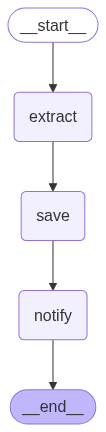

In [6]:
display(
    Image(
        meeting_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Visualize the query workflow

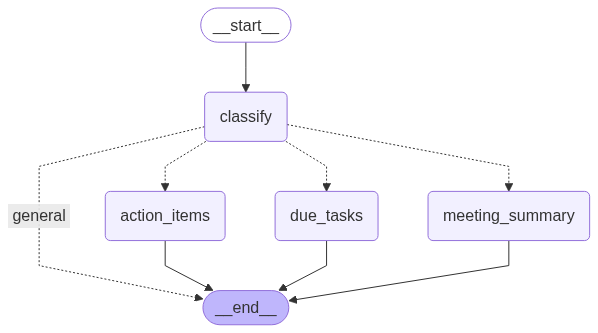

In [7]:
display(
    Image(
        query_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Interface functions

In [8]:
def process_meeting(transcript: str, thread_id: str = "meeting-session"):
    """Process a meeting transcript through the workflow with memory"""
    config = {"configurable": {"thread_id": thread_id}}
    
    result = meeting_app.invoke(
        {
            "transcript": transcript,
            "messages": [{"role": "user", "content": f"Process meeting transcript: {transcript[:100]}..."}]
        }, 
        config
    )
    
    print(f"Meeting {result['meeting_id']}: {len(result['participants'])} participants, {len(result['action_items'])} action items, {len(result['notifications'])} notifications")
    
    return result['meeting_id']

def ask_assistant(query: str, user_name: str = "jane", thread_id: str = "query-session"):
    """Ask the assistant about meetings, tasks, etc. with memory"""
    config = {"configurable": {"thread_id": thread_id}}
    
    result = query_app.invoke({
        "user_query": query,
        "user_name": user_name,
        "messages": [{"role": "user", "content": f"{user_name} asks: {query}"}]
    }, config)
    
    if result.get('response'):
        print(f"{result['response'].strip()}")
    else:
        print("I can help with: due tasks, meeting summaries, or action items.")
    
    return result.get('response', '')

def get_conversation_history(thread_id: str):
    """Get conversation history from memory"""
    config = {"configurable": {"thread_id": thread_id}}
    state = meeting_app.get_state(config)
    return state.values.get("messages", []) if state.values else []

### Test pipeline

In [9]:
print("TESTING LANGGRAPH MEETING PROCESSING WITH MEMORY")
print("=" * 60)

# Test meeting processing with different thread IDs
transcripts = [
    "John and Jane discussed Q3 targets. Jane will prepare the budget report by next Friday. John will reach out to the supplier by Wednesday.",
    "Jane, Bob and Sarah had a follow-up meeting. Bob will create the presentation slides by Monday. Jane will review the budget report by Thursday. Sarah will schedule client calls this week."
]

queries = [
    ("What are my due tasks?", "jane"),
    ("What is the summary of today's meeting?", "bob"), 
    ("What actions do I need to take?", "john")
]

# Process meetings
for i, transcript in enumerate(transcripts, 1):
    print("\n" + "="*40)
    print(f"Meeting {i}")
    print("-"*40)
    meeting_id = process_meeting(transcript, thread_id=f"meeting-{i}")
    print("="*40)

# Test queries
print(f"\n{'='*40}")
print("Query Tests")
print("-"*40)

for query, user in queries:
    print(f"\n{user.title()}: '{query}'")
    ask_assistant(query, user, thread_id=f"{user}-session")

# Demonstrate memory persistence  
print(f"\n{'='*40}")
print("Memory Test")
print("-"*40)

print("\nJane follow-up:")
ask_assistant("Any updates on my tasks?", "jane", "jane-session")

print("\nConversation history sample:")
history = get_conversation_history("jane-session")
print(f"Jane's session: {len(history)} messages")

print("="*60)

TESTING LANGGRAPH MEETING PROCESSING WITH MEMORY

Meeting 1
----------------------------------------
Meeting 20250628_192451: 2 participants, 2 action items, 2 notifications

Meeting 2
----------------------------------------
Meeting 20250628_192453: 3 participants, 3 action items, 3 notifications

Query Tests
----------------------------------------

Jane: 'What are my due tasks?'
Pending tasks for jane:
• prepare the budget report (Due: next Friday)
• Review the budget report (Due: Thursday)

Bob: 'What is the summary of today's meeting?'
Recent meeting summary:
Jane, Bob, and Sarah had a follow-up meeting to discuss action items.

Action items:
• Bob: Create the presentation slides (Due: Monday)
• Jane: Review the budget report (Due: Thursday)
• Sarah: Schedule client calls (Due: This week)

John: 'What actions do I need to take?'
I can help with: due tasks, meeting summaries, or action items.

Memory Test
----------------------------------------

Jane follow-up:
Pending tasks for j